In [483]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, false_discovery_control, wilcoxon, ttest_1samp

## Get the Normalization

In [484]:
from nilearn.image import load_img

In [485]:
comps = [load_img(f"/Users/chris/projects/Nature2023MooneyScripts/results/prediction_error_components/components_{idx}.nii.gz").get_fdata() for idx in range(4)]
comps = [comp[comp != 0] for comp in comps]
comps = [np.linalg.norm(comp) for comp in comps]

## OK

In [486]:
df = pd.read_csv("/Users/chris/projects/Nature2023MooneyScripts/results/prediction_error_components/record.csv")

In [487]:
df.head()

,subject,component_idx,component_value,image_index
0,4,0,0.214458,0
1,4,1,0.235829,0
2,4,2,0.350106,0
3,4,3,0.810492,0
4,4,0,0.359122,1


In [488]:
# Multiply value by the norm to get the actual value
for idx, row in df.iterrows():
    df.loc[idx, "component_value"] = row["component_value"] * comps[int(row["component_idx"])]

[5.63275960e-130 9.47893808e-075 2.10649793e-023]


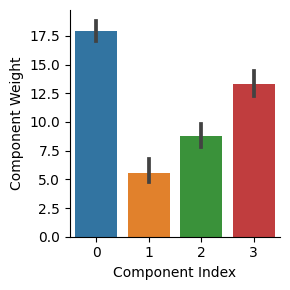

In [489]:
fig, ax = plt.subplots(figsize=(3, 3))
sns.barplot(data=df, x="component_idx", y="component_value", ax=ax)
plt.xlabel("Component Index")
plt.ylabel("Component Weight")

# Test that component 0 is higher than 1, 2, 3, and 4
p_vals = []
comp0 = df[df["component_idx"] == 0]["component_value"]
for i in range(1, 4):
    compi = df[df["component_idx"] == i]["component_value"]
    p_vals.append(mannwhitneyu(comp0, compi)[1])

p_vals = false_discovery_control(p_vals, method="bh")
print(p_vals)

plt.gca().spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.savefig("/Users/chris/Desktop/components_all.png", dpi=1200)

## Which image and subject?

In [490]:
# Load one fmri sequence to get the labels
fmri_sequence = pd.read_csv("/Users/chris/projects/Nature2023MooneyScripts/results/fmri_sequences/human_subject4.csv")

# Make a conversion
index_to_image_name = {}
for i, row in fmri_sequence.iterrows():
    index_to_image_name[row["image_index"]] = row["image_path"].split("/")[-1]

In [491]:
low_threshold = 4
for (subject, image_index), small_df in df.groupby(["subject", "image_index"]):
    # Load the response order
    df_subject = pd.read_excel(f"/Users/chris/projects/Nature2023MooneyScripts/data/fmri_image_order/S{subject}/response_order.xlsx", header=None, names=["image_name", "image_recognized"])

    # Get the image name
    img_name_this = index_to_image_name[image_index]

    # Match with the first row with this image name
    first_row = df_subject[df_subject["image_name"] == img_name_this]

    # Some names are missing a 1
    if len(first_row) == 0:
        img_name_this = img_name_this.replace(".bmp", "1.bmp")
        first_row = df_subject[df_subject["image_name"] == img_name_this]

    recs = first_row["image_recognized"].values
    rec_pre = recs[:len(recs) // 2].mean() >= (6 - low_threshold) / 6
    unrec_pre = recs[:len(recs) // 2].mean() <= (low_threshold) / 6

    rec_post = recs[len(recs) // 2:].mean() >= (6 - low_threshold) / 6
    unrec_post = recs[len(recs) // 2:].mean() <= (low_threshold) / 6

    index = small_df.index
    if unrec_pre and unrec_post:
        df.loc[index, "learning"] = 0
        df.loc[index, "unlearning"] = 1
    elif unrec_pre and rec_post:
        df.loc[index, "learning"] = 1
        df.loc[index, "unlearning"] = 0
    else:
        df.loc[index, "learning"] = 100
        df.loc[index, "unlearning"] = 100

In [492]:
df["learning"].value_counts()

1.0      1164
100.0     940
0.0       404
Name: learning, dtype: int64

In [493]:
# Remove images that are always recognized
df = df[df["learning"] != 100]

In [494]:
df.head()

,subject,component_idx,component_value,image_index,learning,unlearning
8,4,0,15.040171,2,1.0,0.0
9,4,1,1.035298,2,1.0,0.0
10,4,2,7.170261,2,1.0,0.0
11,4,3,0.000000,2,1.0,0.0
28,4,0,39.349952,7,0.0,1.0


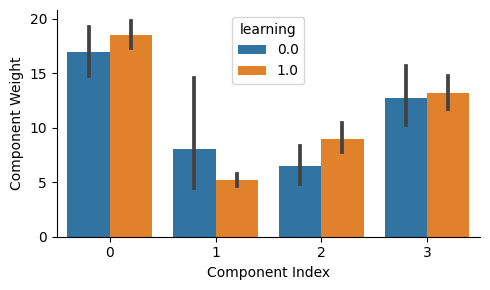

In [495]:
plt.figure(figsize=(5, 3))
sns.barplot(data=df, x="component_idx", y="component_value", hue="learning")
plt.gca().spines[['top', 'right']].set_visible(False)

plt.ylabel("Component Weight")
plt.xlabel("Component Index")

plt.tight_layout()
plt.savefig("/Users/chris/Desktop/components.png", dpi=1200)

In [496]:
# Turn long into wide: component_value_0, component_value_1, component_value_2, becomes columns
df_rotate = pd.pivot_table(df, index=["subject", "image_index", "learning", "unlearning"], columns="component_idx", values="component_value").reset_index()
df_rotate

component_idx,subject,image_index,learning,unlearning,0,1,2,3
0,4,2,1.0,0.0,15.040171,1.035298,7.170261,0.000000
1,4,7,0.0,1.0,39.349952,4.253849,4.369228,6.959214
2,4,12,1.0,0.0,37.638157,11.176328,8.820255,7.956262
3,4,13,1.0,0.0,24.261220,0.000000,11.548771,17.280086
4,4,14,0.0,1.0,4.866461,0.000000,2.956910,29.368540
...,...,...,...,...,...,...,...,...
387,25,24,1.0,0.0,21.339924,3.136590,7.160072,5.460692
388,25,25,1.0,0.0,16.652478,5.358471,9.801678,7.095890
389,25,28,1.0,0.0,12.198598,4.391442,10.863241,15.837474
390,25,29,1.0,0.0,17.703335,5.558810,7.125007,7.555032


## Subject-level pairwise test as first step

In [497]:
from pingouin import pairwise_corr

In [498]:
def get_plot(df_this, condition):
    corr = np.zeros((4, 4, len(df_this["subject"].unique())))
    for subj_idx, (subject, small_df) in enumerate(df_this[df_this["learning"]==condition].groupby("subject")):
        if len(small_df) < 4:
            corr[:, :, subj_idx] = np.nan
            continue

        results = pairwise_corr(small_df, columns=[0, 1, 2, 3], method="bicor")

        for idx, row in results.iterrows():
            corr[row["Y"], row["X"], subj_idx] = row["r"]
            corr[row["X"], row["Y"], subj_idx] = row["r"]

    # Get the lower triangle
    vals = []
    for i in range(4):
        for j in range(i):
            stats = corr[i, j, :]
            vals.append(wilcoxon(stats[~np.isnan(stats)]))
    p_vals = false_discovery_control([v[1] for v in vals], method="bh").tolist()

    p_mat = np.zeros((4, 4))
    for i in range(4):
        for j in range(i):
            val = p_vals.pop(0)
            p_mat[i, j] = val
            p_mat[j, i] = val

    return corr, p_mat

In [499]:
learned_mat, learned_p = get_plot(df_rotate, 1)

In [500]:
unlearned_mat, unlearned_p = get_plot(df_rotate, 0)

/opt/anaconda3/envs/nature2023/lib/python3.11/site-packages/pingouin/power.py:861: UserWarning: Sample size is too small to estimate power (n <= 4). Returning NaN.
  warnings.warn("Sample size is too small to estimate power (n <= 4). Returning NaN.")
/opt/anaconda3/envs/nature2023/lib/python3.11/site-packages/pingouin/power.py:861: UserWarning: Sample size is too small to estimate power (n <= 4). Returning NaN.
  warnings.warn("Sample size is too small to estimate power (n <= 4). Returning NaN.")
/opt/anaconda3/envs/nature2023/lib/python3.11/site-packages/pingouin/power.py:861: UserWarning: Sample size is too small to estimate power (n <= 4). Returning NaN.
  warnings.warn("Sample size is too small to estimate power (n <= 4). Returning NaN.")
/opt/anaconda3/envs/nature2023/lib/python3.11/site-packages/pingouin/power.py:861: UserWarning: Sample size is too small to estimate power (n <= 4). Returning NaN.
  warnings.warn("Sample size is too small to estimate power (n <= 4). Returning NaN

/var/folders/js/6gw33t_51rqcvbmgmlr5ybtw0000gn/T/ipykernel_23370/2890800157.py:9: RuntimeWarning: All-NaN slice encountered
  heatmap1 = sns.heatmap(np.nanmedian(this_coef, axis=-1), cmap="coolwarm", vmin=-0.5, vmax=0.5, cbar=False, ax=axes[this_idx])
/var/folders/js/6gw33t_51rqcvbmgmlr5ybtw0000gn/T/ipykernel_23370/2890800157.py:9: RuntimeWarning: All-NaN slice encountered
  heatmap1 = sns.heatmap(np.nanmedian(this_coef, axis=-1), cmap="coolwarm", vmin=-0.5, vmax=0.5, cbar=False, ax=axes[this_idx])


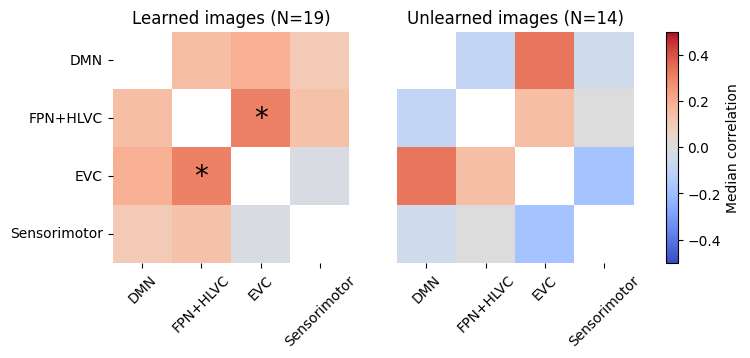

In [513]:
network_names = ["DMN", "FPN+HLVC", "EVC", "Sensorimotor"]
fig, axes = plt.subplots(1, 2, figsize=(8.4, 3))

for this_idx, (this_coef, p_mat, this_name) in enumerate(zip([learned_mat, unlearned_mat], [learned_p, unlearned_p], ["Learned", "Unlearned"])):
    this_coef = this_coef.copy()

    # Set the diagonal to nan
    this_coef[np.eye(4, dtype=bool)] = np.nan
    heatmap1 = sns.heatmap(np.nanmedian(this_coef, axis=-1), cmap="coolwarm", vmin=-0.5, vmax=0.5, cbar=False, ax=axes[this_idx])

    # Number of images
    n_imgs = (~np.isnan(this_coef[0, 1, :])).sum()

    for i in range(p_mat.shape[1]):
        for j in range(p_mat.shape[0]):
            if np.isnan(p_mat[i, j]) or i == j:
                continue

            if p_mat[i, j] < 0.05:
                axes[this_idx].text(i+0.5, j+0.5, "*", ha='center', va='center', color="black", fontsize=20)

    axes[this_idx].set_title(f"{this_name} images (N={n_imgs})")
    axes[this_idx].set_ylabel("")
    axes[this_idx].set_xlabel("")

    # Set the ticks
    axes[this_idx].set_xticks(ticks=np.arange(4) + 0.5, labels=network_names, rotation=45)
    if this_idx == 0:
        axes[this_idx].set_yticks(ticks=np.arange(4) + 0.5, labels=network_names, rotation=0)
    else:
        axes[this_idx].set_yticks([], [])

# Create a colorbar to the right without being in 2nd axis
plt.colorbar(heatmap1.get_children()[0], ax=axes, orientation='vertical', label="Median correlation")

# plt.tight_layout()
plt.savefig("/Users/chris/Desktop/correlation_mats.png", dpi=1200, bbox_inches="tight")

In [502]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Linear model on volume

In [503]:
df_volume = df.copy()

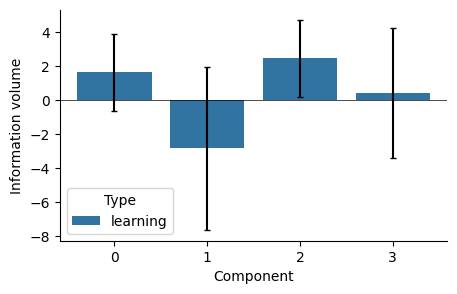

In [504]:
m2_df = {"Type": [], "Component": [], "coef": [], "ci_low": [], "ci_high": [], "p": []}
for component_idx, small_df in df_volume.groupby("component_idx"):
    model = smf.gee(
        "component_value ~ learning",
        data=small_df,
        groups="subject",
        cov_struct=sm.cov_struct.Independence()
    )
    m2 = model.fit()

    # First one is failed to xxx, and second one is success xxx
    m2_df["Component"].append(component_idx)
    m2_df["Type"].append("learning")
    m2_df["ci_low"].append(m2.conf_int().iloc[1, 0])
    m2_df["ci_high"].append(m2.conf_int().iloc[1, 1])
    m2_df["coef"].append(m2.params[1])
    m2_df["p"].append(m2.pvalues[1])

m2_df["q"] = false_discovery_control(m2_df["p"], method="bh")
m2_df = pd.DataFrame(m2_df)
m2_df = m2_df.sort_values(["Type", "Component"])

plt.figure(figsize=(5, 3))

# Calculate the error bars as the difference from the estimate
m2_df['err_lower'] = m2_df['coef'] - m2_df['ci_low']
m2_df['err_upper'] = m2_df['ci_high'] - m2_df['coef']

barplot = sns.barplot(data=m2_df, x="Component", y="coef", hue="Type")

# Manually add error bars
bars = barplot.patches
group_width = bars[0].get_width()
for i in range(len(m2_df)):
    bar = bars[i]
    center = bar.get_x() + bar.get_width() / 2
    plt.errorbar(x=center, y=m2_df['coef'].iloc[i], 
                 yerr=[[m2_df['err_lower'].iloc[i]], [m2_df['err_upper'].iloc[i]]],
                 fmt='none', capsize=2, color='black')
    
    # If significant, add a star
    if m2_df['q'].iloc[i] < 0.05:
        if m2_df["coef"].iloc[i] > 0:
            plt.text(center + 0.1, m2_df['coef'].iloc[i] + 0.6, "*", ha='center', va='center', color="black", fontsize=12)
        if m2_df["coef"].iloc[i] < 0:
            plt.text(center + 0.1, m2_df['coef'].iloc[i] - 0.6, "*", ha='center', va='center', color="black", fontsize=12)

plt.gca().spines[['top', 'right']].set_visible(False)
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel("Information volume")
plt.savefig("/Users/chris/Desktop/volume.png", dpi=1200)